In [1]:
import numpy as np
import pandas as pd

In [170]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
data = pd.read_csv('tic-tac-toe.data.txt', header=None)

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [15]:
X, y = data[np.arange(9)], np.array(data[9].values == 'positive',dtype=int)

In [30]:
X_binarised = pd.concat([pd.get_dummies(X[col]) for col in X.columns],axis=1).values
assert X_binarised.shape == (X.shape[0], X.shape[1] * 3)

In [32]:
from sklearn.model_selection import ShuffleSplit

In [36]:
X_train,y_train = X_binarised, y

In [41]:
x = X_train[-1]

In [205]:
def solve(X_train, X_test, y_train, aggr):
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    pred = np.zeros(X_test.shape[0])
    for i,x in enumerate(X_test):
        inter_pos = (X_train_pos == x)
        inter_neg = (X_train_neg == x)
        closure_pos = np.array([np.all(x[context] == X_train_pos[:, context], axis=1) for context in inter_pos])
        closure_neg = np.array([np.all(x[context] == X_train_neg[:, context], axis=1) for context in inter_neg])
        score = lambda X: float(np.sum(X) / np.sum(np.ones(X.shape)))
        pred[i] = aggr(score(closure_pos), score(closure_neg)) > 0
    return pred

In [206]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [209]:
def cross_val_scores(X, y, calc_f):
    acc, prec, rec, f1 = [], [], [], []
    for train_id, val_id in ShuffleSplit(n_splits=3, random_state=42).split(X, y):
        X_train, X_val = X_binarised[train_id], X_binarised[val_id]
        y_train, y_val = y[train_id], y[val_id]
        y_pred = calc_f(X_train, X_val, y_train)
        acc.append(accuracy_score(y_val, y_pred))
        prec.append(precision_score(y_val, y_pred))
        rec.append(recall_score(y_val, y_pred))
        f1.append(f1_score(y_val, y_pred))
    return np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

In [210]:
acc, prec, rec, f1 = [], [], [], []
l = np.linspace(0.5, 1, 20)
from tqdm import tqdm
for coef in tqdm(l, position=0):
    f = lambda a, b: a - coef * b
    a, p, r, fm = cross_val_scores(X, y, lambda X,y,X_t: solve(X, y, X_t, f))
    acc.append(a)
    prec.append(p)
    rec.append(r)
    f1.append(fm)
#     print(f'C={coef},acc={a},precision={p},recall={r}')

100%|██████████| 20/20 [07:14<00:00, 21.74s/it]


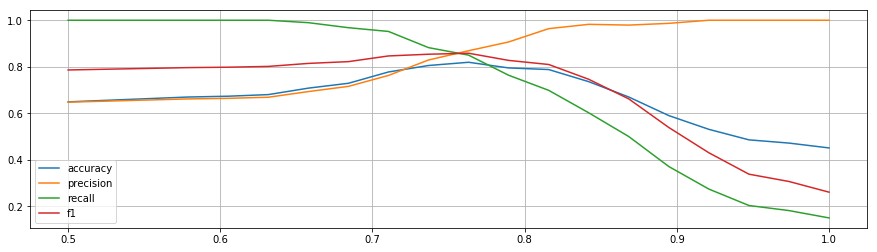

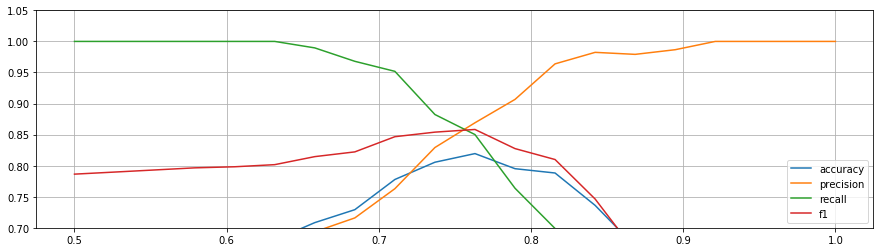

In [202]:
plt.figure(figsize=(15,4))
plt.plot(l, acc, label='accuracy')
plt.plot(l, prec, label='precision')
plt.plot(l, rec, label='recall')
plt.plot(l, f1, label='f1')
plt.grid(True)
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(15,4))
plt.plot(l, acc, label='accuracy')
plt.plot(l, prec, label='precision')
plt.plot(l, rec, label='recall')
plt.plot(l, f1, label='f1')
plt.grid(True)
plt.ylim([0.7,1.05])
plt.legend(loc='best')
plt.show()